<a href="https://colab.research.google.com/github/steve-shim/dlgom/blob/main/deeplearning/%EA%B0%80%EC%A4%91%EC%B9%98_%EC%B4%88%EA%B8%B0%ED%99%94%2C_%EB%B0%B0%EC%B9%98_%EC%A0%95%EA%B7%9C%ED%99%94_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import numpy as np

class MultiClassNetwork:

  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
      self.units = units  # 은닉층의 뉴런 개수(100)
      self.batch_size = batch_size
      self.w1 = None  # 은닉층에 적용되는 가중치
      self.b1 = None  # 은닉층의 절편
      self.w2 = None  # 출력층에 적용되는 가중치
      self.b2 = None  # 출력층의 절편
      self.a1 = None  # 은닉층의 활성화 출력
      self.losses = []     # 훈련 손실
      self.val_losses = [] # 검증 손실
      self.lr = learning_rate
      self.l1 = l1
      self.l2 = l2

  def forpass(self, x):             # x_batch:(256,784)
      z1 = np.dot(x, self.w1) + self.b1  # (256,784) @ (784,100) -> (256,100)
      self.a1 = self.sigmoid(z1)    
      z2 = np.dot(self.a1, self.w2) + self.b2 # (256,100) @ (100,10) -> (256,10)
      return z2

  def backprop(self, x, err): # (256,784), (256,10)
      m = len(x) # 샘플 개수
      # 출력층의 가중치와 절편에 대한 그레이디언트를 계산
      w2_grad = np.dot(self.a1.T, err) / m  # (100,256) @ (256,10) -> (100,10)
      b2_grad = np.sum(err, axis=0) / m
      # 시그모이드 함수까지 그레이디언트를 계산
      err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1-self.a1) # (256,10) @ (10,100) -> (256,100)
      # 은닉층의 가중치와 절편에 대한 그레이디언트를 계산
      w1_grad = np.dot(x.T, err_to_hidden) / m # (784,256) @ (256,100) -> (784,100)
      b1_grad = np.sum(err_to_hidden, axis=0) / m # (256,100) -> (100,)
      return w1_grad, b1_grad, w2_grad, b2_grad

  def sigmoid(self, z):
      z = np.clip(z, -100, None)
      a = 1 / (1 + np.exp(-z))
      return a

  def softmax(self, z):
      z = np.clip(z, -100, None)
      exp_z = np.exp(z)
      return exp_z / np.sum(exp_z, axis=1).reshape(-1,1)

  def init_weights(self, n_features, n_classes): # 784, 10
      self.w1 = np.random.normal(0, 1, 
                                (n_features, self.units)) # (특성 개수, 은닉층의 크기) 은닉층에 적용되는 가중치
      self.b1 = np.zeros(self.units) # 은닉층의 뉴런의 갯수만큼 은닉층의 바이어스가 정해진다
      self.w2 = np.random.normal(0, 1, 
                                (self.units, n_classes))  # (은닉층의 크기, 클래스 개수)
      self.b2 = np.zeros(n_classes)  # 클래스 갯수만큼 바이어스값 초기화

  def fit(self, x, y, epochs=100, x_val=None, y_val=None): # x:(48000,784) y:(48000,10) x_val:(12000,784), y_val:(12000,10)
      np.random.seed(42)
      self.init_weights(x.shape[1], y.shape[1]) # 784, 10
      # epochs만큼 반복
      for i in range(epochs):
        loss = 0 # epochs 마다 손실을 기록한다
        print('.', end='')
        # 제너레이터 함수에서 반환한 미니 배치를 순환합니다
        for x_batch, y_batch in self.gen_batch(x, y):  # x:(48000,784) y:(48000,10)
          a = self.training(x_batch, y_batch)          # x_batch:(256,784) y_batch:(256,10) -> a:(256,10)
          a = np.clip(a, 1e-10, 1-1e-10)
          loss += np.sum(-y_batch * np.log(a))         # loss -> 스칼라값
        self.losses.append((loss + self.reg_loss()) / len(x)) # 훈련세트 전체 크기로 나눈다 (48000)
        # epoch 마다 검증 세트에 대한 손실 계산
        self.update_val_loss(x_val, y_val)             # x_val:(12000,784), y_val:(12000,10)

    
  def gen_batch(self, x, y): # x:(48000,784) y:(48000,10)
      length = len(x)  # 48000
      bins = length // self.batch_size # 48000/256 -> 187.5
      if length % self.batch_size: # 미니배치횟수 187+1 -> 188회
        bins += 1 
      indexes = np.random.permutation(np.arange(len(x))) # 전체 인덱스를 섞는다
      x = x[indexes]
      y = y[indexes]
      for i in range(bins): # 미니배치횟수만큼 루프를 돈다 (48000 = 256 x 187 + 128 x 1)
        start = self.batch_size * i
        end = self.batch_size * (i+1)
        yield x[start:end], y[start:end] # batch_size만큼 슬라이싱하여 반환

  def training(self, x, y): # x_batch:(256,784) y_batch:(256,10)
      m = len(x)              # 256
      z = self.forpass(x)     # x_batch:(256,784) -> (256,10)
      a = self.softmax(z)     # 활성화 함수적용(다중분류니까 softmax!) -> (256,10)
      err = -(y-a)            # (256,10)
      w1_grad , b1_grad, w2_grad, b2_grad = self.backprop(x, err) # (256,784), (256,10)
      w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m  # 배치사이즈로 나눈다 (256)
      w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m  # 배치사이즈로 나눈다
      # 은닉층의 가중치와 절편을 업데이트
      self.w1 -= self.lr * w1_grad
      self.b1 -= self.lr * b1_grad
      # 출력층의 가중치와 절편을 업데이트
      self.w2 -= self.lr * w2_grad
      self.b2 -= self.lr * b2_grad
      return a  # (256,10)

  def predict(self, x):   # x:(12000, 784)
      z = self.forpass(x) # z:(12000, 10)
      return np.argmax(z, axis=1) # (12000,) -> 각 샘플의 10개 클래스 중에서 가장 예측확률이 높은 인덱스를 반환

  def score(self, x, y):  # x:(12000, 784), y:(12000, 10) = (검증세트 정답)
      # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환
      return np.mean(self.predict(x) == np.argmax(y, axis=1)) # (12000,) == (12000,)

  def reg_loss(self):
      # 은닉층과 출력층의 가중치에 규제를 적용
      return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
             self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

  def update_val_loss(self, x_val, y_val):
      z = self.forpass(x_val) # (12000, 10)
      a = self.softmax(z) # (12000, 10)
      a = np.clip(a, 1e-10, 1-1e-10) 
      val_loss = np.sum(-y_val * np.log(a))
      self.val_losses.append((val_loss + self.reg_loss()) / len(y_val)) # 검증 데이터 전체 크기로 나눈다 (12000)


  
      

In [23]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

print(x_train_all.shape, y_train_all.shape)
print(x_test.shape, y_test.shape)
print(x_train.shape, x_val.shape)
print(y_train.shape, y_val.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
(48000, 28, 28) (12000, 28, 28)
(48000,) (12000,)


In [24]:
#np.bincount(y_train)
np.unique(y_train, return_counts=True)[1]

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800])

(28, 28)


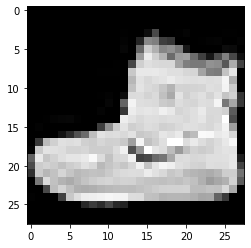

In [25]:
import matplotlib.pyplot as plt

print(x_train_all[0].shape)
plt.imshow(x_train_all[0], cmap='gray')
plt.show()

In [26]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [27]:
x_train = x_train / 255
x_val = x_val / 255

x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)

print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [28]:
tf.keras.utils.to_categorical([0, 1, 3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [29]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [30]:
print(y_train.shape, y_val.shape)
print(y_train_encoded.shape, y_val_encoded.shape)
print(y_train[0], y_train_encoded[0])

(48000,) (12000,)
(48000, 10) (12000, 10)
6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [31]:
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, 
       x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

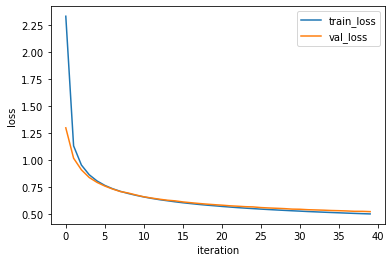

In [32]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [33]:
fc.score(x_val, y_val_encoded)

0.81475

In [34]:
fc.score(x_train, y_train_encoded)

0.8215625

가중치 초기화를 할때 Xavier/He 방식을 사용하면 정확도가 더 올라간다! 

In [36]:
import numpy as np

class MultiClassNetwork2:

  def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
      self.units = units  # 은닉층의 뉴런 개수(100)
      self.batch_size = batch_size
      self.w1 = None  # 은닉층에 적용되는 가중치
      self.b1 = None  # 은닉층의 절편
      self.w2 = None  # 출력층에 적용되는 가중치
      self.b2 = None  # 출력층의 절편
      self.a1 = None  # 은닉층의 활성화 출력
      self.losses = []     # 훈련 손실
      self.val_losses = [] # 검증 손실
      self.lr = learning_rate
      self.l1 = l1
      self.l2 = l2

  def forpass(self, x):             # x_batch:(256,784)
      z1 = np.dot(x, self.w1) + self.b1  # (256,784) @ (784,100) -> (256,100)
      self.a1 = self.sigmoid(z1)    
      z2 = np.dot(self.a1, self.w2) + self.b2 # (256,100) @ (100,10) -> (256,10)
      return z2

  def backprop(self, x, err): # (256,784), (256,10)
      m = len(x) # 샘플 개수
      # 출력층의 가중치와 절편에 대한 그레이디언트를 계산
      w2_grad = np.dot(self.a1.T, err) / m  # (100,256) @ (256,10) -> (100,10)
      b2_grad = np.sum(err, axis=0) / m
      # 시그모이드 함수까지 그레이디언트를 계산
      err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1-self.a1) # (256,10) @ (10,100) -> (256,100)
      # 은닉층의 가중치와 절편에 대한 그레이디언트를 계산
      w1_grad = np.dot(x.T, err_to_hidden) / m # (784,256) @ (256,100) -> (784,100)
      b1_grad = np.sum(err_to_hidden, axis=0) / m # (256,100) -> (100,)
      return w1_grad, b1_grad, w2_grad, b2_grad

  def sigmoid(self, z):
      z = np.clip(z, -100, None)
      a = 1 / (1 + np.exp(-z))
      return a

  def softmax(self, z):
      z = np.clip(z, -100, None)
      exp_z = np.exp(z)
      return exp_z / np.sum(exp_z, axis=1).reshape(-1,1)

  def init_weights(self, n_features, n_classes): # 784, 10
      self.w1 = np.random.normal(0, 1, 
                                (n_features, self.units)) * (np.sqrt(2/n_features)) # (특성 개수, 은닉층의 크기) 은닉층에 적용되는 가중치
      self.b1 = np.zeros(self.units) # 은닉층의 뉴런의 갯수만큼 은닉층의 바이어스가 정해진다
      self.w2 = np.random.normal(0, 1, 
                                (self.units, n_classes)) * (np.sqrt(2/self.units)) # (은닉층의 크기, 클래스 개수)
      self.b2 = np.zeros(n_classes)  # 클래스 갯수만큼 바이어스값 초기화

  def fit(self, x, y, epochs=100, x_val=None, y_val=None): # x:(48000,784) y:(48000,10) x_val:(12000,784), y_val:(12000,10)
      np.random.seed(42)
      self.init_weights(x.shape[1], y.shape[1]) # 784, 10
      # epochs만큼 반복
      for i in range(epochs):
        loss = 0 # epochs 마다 손실을 기록한다
        print('.', end='')
        # 제너레이터 함수에서 반환한 미니 배치를 순환합니다
        for x_batch, y_batch in self.gen_batch(x, y):  # x:(48000,784) y:(48000,10)
          a = self.training(x_batch, y_batch)          # x_batch:(256,784) y_batch:(256,10) -> a:(256,10)
          a = np.clip(a, 1e-10, 1-1e-10)
          loss += np.sum(-y_batch * np.log(a))         # loss -> 스칼라값
        self.losses.append((loss + self.reg_loss()) / len(x)) # 훈련세트 전체 크기로 나눈다 (48000)
        # epoch 마다 검증 세트에 대한 손실 계산
        self.update_val_loss(x_val, y_val)             # x_val:(12000,784), y_val:(12000,10)

    
  def gen_batch(self, x, y): # x:(48000,784) y:(48000,10)
      length = len(x)  # 48000
      bins = length // self.batch_size # 48000/256 -> 187.5
      if length % self.batch_size: # 미니배치횟수 187+1 -> 188회
        bins += 1 
      indexes = np.random.permutation(np.arange(len(x))) # 전체 인덱스를 섞는다
      x = x[indexes]
      y = y[indexes]
      for i in range(bins): # 미니배치횟수만큼 루프를 돈다 (48000 = 256 x 187 + 128 x 1)
        start = self.batch_size * i
        end = self.batch_size * (i+1)
        yield x[start:end], y[start:end] # batch_size만큼 슬라이싱하여 반환

  def training(self, x, y): # x_batch:(256,784) y_batch:(256,10)
      m = len(x)              # 256
      z = self.forpass(x)     # x_batch:(256,784) -> (256,10)
      a = self.softmax(z)     # 활성화 함수적용(다중분류니까 softmax!) -> (256,10)
      err = -(y-a)            # (256,10)
      w1_grad , b1_grad, w2_grad, b2_grad = self.backprop(x, err) # (256,784), (256,10)
      w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m  # 배치사이즈로 나눈다 (256)
      w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m  # 배치사이즈로 나눈다
      # 은닉층의 가중치와 절편을 업데이트
      self.w1 -= self.lr * w1_grad
      self.b1 -= self.lr * b1_grad
      # 출력층의 가중치와 절편을 업데이트
      self.w2 -= self.lr * w2_grad
      self.b2 -= self.lr * b2_grad
      return a  # (256,10)

  def predict(self, x):   # x:(12000, 784)
      z = self.forpass(x) # z:(12000, 10)
      return np.argmax(z, axis=1) # (12000,) -> 각 샘플의 10개 클래스 중에서 가장 예측확률이 높은 인덱스를 반환

  def score(self, x, y):  # x:(12000, 784), y:(12000, 10) = (검증세트 정답)
      # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환
      return np.mean(self.predict(x) == np.argmax(y, axis=1)) # (12000,) == (12000,)

  def reg_loss(self):
      # 은닉층과 출력층의 가중치에 규제를 적용
      return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
             self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

  def update_val_loss(self, x_val, y_val):
      z = self.forpass(x_val) # (12000, 10)
      a = self.softmax(z) # (12000, 10)
      a = np.clip(a, 1e-10, 1-1e-10) 
      val_loss = np.sum(-y_val * np.log(a))
      self.val_losses.append((val_loss + self.reg_loss()) / len(y_val)) # 검증 데이터 전체 크기로 나눈다 (12000)


  
      

In [45]:
fc = MultiClassNetwork2(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded, 
       x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

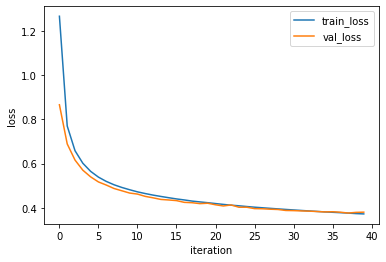

In [46]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [47]:
fc.score(x_val, y_val_encoded)

0.8635

In [48]:
fc.score(x_train, y_train_encoded)

0.8653333333333333

tensorflow 프레임워크는 가중치 초기화시 Xavier/He 방식이 내장되어 있다

In [49]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()
model.add(Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train_encoded, epochs=40,
                    validation_data=(x_val, y_val_encoded))


Epoch 1/40
1500/1500 [==============================] - 4s 2ms/step - loss: 1.3852 - accuracy: 0.6338 - val_loss: 0.9739 - val_accuracy: 0.7297
Epoch 2/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.8512 - accuracy: 0.7418 - val_loss: 0.7566 - val_accuracy: 0.7584
Epoch 3/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.7161 - accuracy: 0.7632 - val_loss: 0.6668 - val_accuracy: 0.7814
Epoch 4/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6497 - accuracy: 0.7781 - val_loss: 0.6148 - val_accuracy: 0.7908
Epoch 5/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6072 - accuracy: 0.7916 - val_loss: 0.5797 - val_accuracy: 0.8058
Epoch 6/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5765 - accuracy: 0.8018 - val_loss: 0.5538 - val_accuracy: 0.8086
Epoch 7/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5531 - accuracy: 0.8096 - val_loss: 0.5367 - val_accuracy:

In [50]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


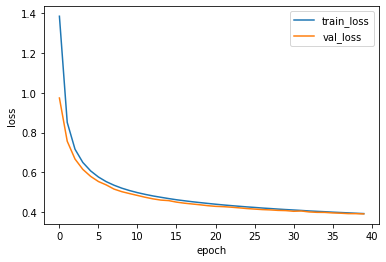

In [51]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

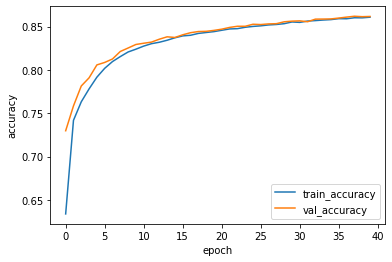

In [52]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [53]:
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
model.evaluate(x_val, y_val_encoded, verbose=0)

[0.3908236622810364, 0.8616666793823242]

**배치 정규화 추가**

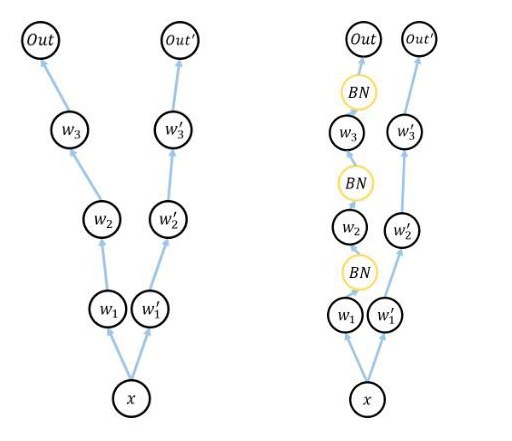

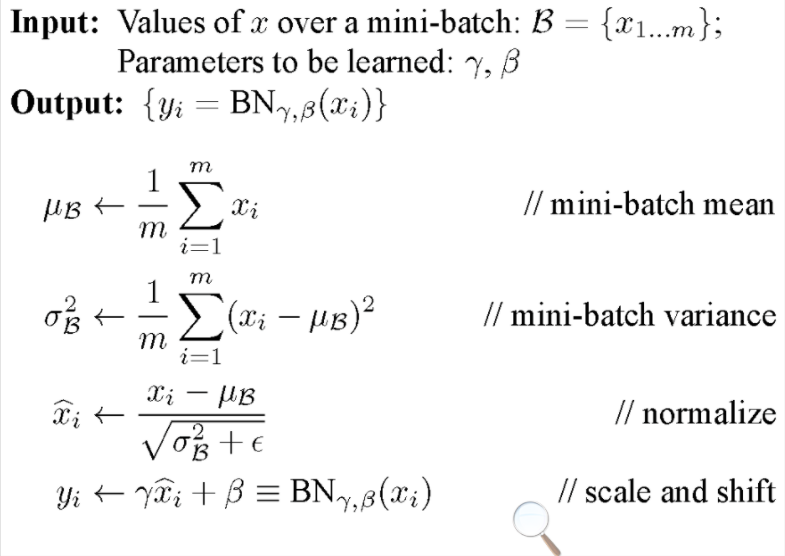

In [54]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

model2 = Sequential()
model2.add(Dense(100, activation='sigmoid', input_shape=(784,)))
model2.add(BatchNormalization())
model2.add(Dense(10, activation='softmax'))
model2.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model2.fit(x_train, y_train_encoded, epochs=40,
                    validation_data=(x_val, y_val_encoded))


Epoch 1/40
1500/1500 [==============================] - 4s 2ms/step - loss: 0.6025 - accuracy: 0.7921 - val_loss: 0.4720 - val_accuracy: 0.8359
Epoch 2/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4895 - accuracy: 0.8296 - val_loss: 0.4473 - val_accuracy: 0.8450
Epoch 3/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4611 - accuracy: 0.8401 - val_loss: 0.4318 - val_accuracy: 0.8499
Epoch 4/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4450 - accuracy: 0.8432 - val_loss: 0.4210 - val_accuracy: 0.8518
Epoch 5/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4309 - accuracy: 0.8497 - val_loss: 0.4174 - val_accuracy: 0.8528
Epoch 6/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4216 - accuracy: 0.8525 - val_loss: 0.4239 - val_accuracy: 0.8524
Epoch 7/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4148 - accuracy: 0.8541 - val_loss: 0.3940 - val_accuracy:

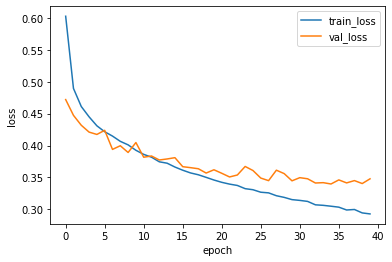

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

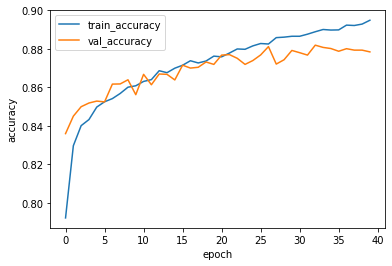

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [63]:
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
model2.evaluate(x_val, y_val_encoded, verbose=0)

[0.3478849232196808, 0.8784166574478149]

In [59]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization

model3 = Sequential()
model3.add(Dense(100, activation='relu', input_shape=(784,)))
model3.add(BatchNormalization())
model3.add(Dense(10, activation='softmax'))
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model3.fit(x_train, y_train_encoded, epochs=40,
                    validation_data=(x_val, y_val_encoded))


Epoch 1/40
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5153 - accuracy: 0.8207 - val_loss: 0.5247 - val_accuracy: 0.7980
Epoch 2/40
1500/1500 [==============================] - 4s 3ms/step - loss: 0.4189 - accuracy: 0.8510 - val_loss: 0.4434 - val_accuracy: 0.8393
Epoch 3/40
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3858 - accuracy: 0.8614 - val_loss: 0.4218 - val_accuracy: 0.8474
Epoch 4/40
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3649 - accuracy: 0.8680 - val_loss: 0.3747 - val_accuracy: 0.8662
Epoch 5/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3510 - accuracy: 0.8743 - val_loss: 0.3410 - val_accuracy: 0.8787
Epoch 6/40
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3386 - accuracy: 0.8767 - val_loss: 0.3792 - val_accuracy: 0.8676
Epoch 7/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3289 - accuracy: 0.8805 - val_loss: 0.3638 - val_accuracy:

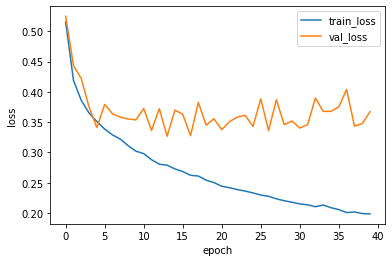

In [60]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

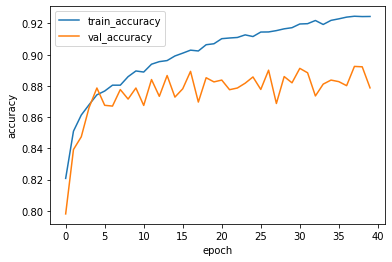

In [61]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [64]:
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
model3.evaluate(x_val, y_val_encoded, verbose=0)

[0.36728882789611816, 0.8787500262260437]

**Dropout 적용**

오버피팅을 억제하기 위해서 뉴런을 임의로 삭제하면서 학습시키는 방법

In [65]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

model4 = Sequential()
model4.add(Dense(100, activation='relu', input_shape=(784,)))
model4.add(BatchNormalization())
model4.add(Dropout(0.2))
model4.add(Dense(10, activation='softmax'))
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model4.fit(x_train, y_train_encoded, epochs=40,
                    validation_data=(x_val, y_val_encoded))


Epoch 1/40
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5527 - accuracy: 0.8066 - val_loss: 0.4612 - val_accuracy: 0.8307
Epoch 2/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4563 - accuracy: 0.8385 - val_loss: 0.4073 - val_accuracy: 0.8562
Epoch 3/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4342 - accuracy: 0.8453 - val_loss: 0.3716 - val_accuracy: 0.8675
Epoch 4/40
1500/1500 [==============================] - 4s 2ms/step - loss: 0.4158 - accuracy: 0.8502 - val_loss: 0.3936 - val_accuracy: 0.8645
Epoch 5/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3998 - accuracy: 0.8563 - val_loss: 0.3832 - val_accuracy: 0.8586
Epoch 6/40
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3880 - accuracy: 0.8578 - val_loss: 0.3545 - val_accuracy: 0.8765
Epoch 7/40
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3796 - accuracy: 0.8608 - val_loss: 0.3575 - val_accuracy:

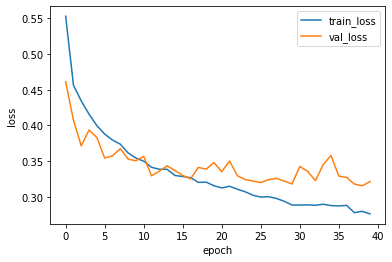

In [66]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

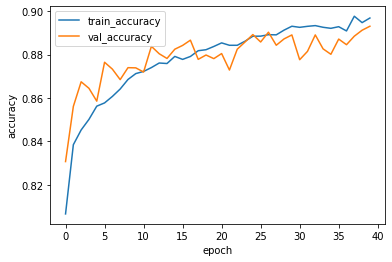

In [67]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [69]:
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
model4.evaluate(x_val, y_val_encoded, verbose=0)

[0.32167914509773254, 0.8930833339691162]

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**EarlyStopping** val_loss 의 변화를 보다가 3epoch 동안 val_loss값이 떨어지지 않는다면 학습을 조기 종료한다 

**ModelCheckpoint** save_best_only=True 조기종료 시점으로부터 이전에 손실이 가장 낮았던 순간의 최적모델을 저장한다

In [79]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

model5 = Sequential()
model5.add(Dense(100, activation='relu', input_shape=(784,)))
model5.add(BatchNormalization())
model5.add(Dropout(0.2))
model5.add(Dense(100, activation='relu'))
model5.add(BatchNormalization())
#model5.add(Dropout(0.2))
model5.add(Dense(10, activation='softmax'))

es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
mc = ModelCheckpoint('./best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

model5.compile(optimizer='adam', 
               loss='categorical_crossentropy', 
               metrics=['acc'])

history = model5.fit(x_train, y_train_encoded, epochs=40,
                    validation_data=(x_val, y_val_encoded),
                    callbacks=[es, mc])



Epoch 1/40
1500/1500 [==============================] - 6s 3ms/step - loss: 0.5641 - acc: 0.7996 - val_loss: 0.4066 - val_acc: 0.8546
Epoch 2/40
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4496 - acc: 0.8365 - val_loss: 0.3954 - val_acc: 0.8557
Epoch 3/40
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4182 - acc: 0.8487 - val_loss: 0.3777 - val_acc: 0.8636
Epoch 4/40
1500/1500 [==============================] - 5s 3ms/step - loss: 0.4017 - acc: 0.8548 - val_loss: 0.3670 - val_acc: 0.8659
Epoch 5/40
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3882 - acc: 0.8582 - val_loss: 0.3841 - val_acc: 0.8580
Epoch 6/40
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3725 - acc: 0.8639 - val_loss: 0.3550 - val_acc: 0.8719
Epoch 7/40
1500/1500 [==============================] - 4s 3ms/step - loss: 0.3701 - acc: 0.8647 - val_loss: 0.3671 - val_acc: 0.8693
Epoch 8/40
1500/1500 [==============================] - 4s 3ms

In [80]:
new_model = tf.keras.models.load_model('best_model.h5')

In [84]:
new_model.evaluate(x_val, y_val_encoded, verbose=0)

[0.30521485209465027, 0.8892499804496765]